# WAMBS Python Tutorial

**Author**: original R Tutorial created by Laurent Smeets and Rens van de Schoot, with updates by Duco Veen; Python translation by Florian Metwaly

In this tutorial you follow the steps of the when-to-Worry-and-How-to-Avoid-the-Misuse-of-Bayesian-Statistics - checklist [(the WAMBS-checklist)](https://www.rensvandeschoot.com/wambs-checklist/).

## WAMBS Checklist

### *When to worry, and how to Avoid the Misuse of Bayesian Statistics*

**To be checked before estimating the model**

1. Do you understand the priors?

**To be checked after estimation but before inspecting model results**

2.    Does the trace-plot exhibit convergence?
3.  Does convergence remain after doubling the number of iterations?
4.   Does the posterior distribution histogram have enough information?
5.   Do the chains exhibit a strong degree of autocorrelation?
6.   Do the posterior distributions make substantive sense?

**Understanding the exact influence of the priors**

7. Do different specification of the multivariate variance priors influence the results?
8.   Is there a notable effect of the prior when compared with non-informative priors?
9.   Are the results stable from a sensitivity analysis?
10.   Is the Bayesian way of interpreting and reporting model results used?

## Example Data

The data we be use for this exercise is based on a study about predicting PhD-delays ([Van de Schoot, Yerkes, Mouw and Sonneveld 2013](http://journals.plos.org/plosone/article?id=10.1371/journal.pone.0068839)).  The data can be downloaded [here](https://www.rensvandeschoot.com/wp-content/uploads/2018/10/phd-delays.csv). Among many other questions, the researchers asked the Ph.D. recipients how long it took them to finish their Ph.D. thesis (n=333). It appeared that Ph.D. recipients took an average of 59.8 months (five years and four months) to complete their Ph.D. trajectory. The variable B3_difference_extra measures the difference between planned and actual project time in months (mean=9.96, minimum=-31, maximum=91, sd=14.43). For more information on the sample, instruments, methodology and research context we refer the interested reader to the paper.

For the current exercise we are interested in the question whether age (M = 30.7, SD = 4.48, min-max = 26-69) of the Ph.D. recipients is related to a delay in their project.

The relation between completion time and age is expected to be non-linear. This might be due to that at a certain point in your life (i.e., mid thirties), family life takes up more of your time than when you are in your twenties or when you are older.

So, in our model the gap (*B3_difference_extra*) is the dependent variable and age (*E22_Age*) and age$^2$(*E22_Age_Squared *) are the predictors. The data can be found in the file <span style="color:red"> ` phd-delays.csv` </span>.



##### _**Question:** Write down the null and alternative hypotheses that represent this question. Which hypothesis do you deem more likely?_

<details>
<summary>Click to show result</summary>
$H_0:$ _$age$ is not related to a delay in the PhD projects._

$H_1:$ _$age$ is related to a delay in the PhD projects._

$H_0:$ _$age^2$ is not related to a delay in the PhD projects._

$H_1:$ _$age^2$ is related to a delay in the PhD projects._

</details>

## Preparation - Importing and Exploring Data

If you are using Google Colab, remove the # from the following line and run the chunk to install the bambi library:

In [1]:
#!pip install bambi

In [2]:
import bambi as bmb # BAyesian Model-Building Interface in Python
import arviz as az # Exploratory analysis of Bayesian models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting

SEED = 1337 # set a seed to get consistent results

You can find the data in the file <span style="color:red"> ` phd-delays.csv` </span>, which contains all variables that you need for this analysis. Although it is a .csv-file, you can directly load it into Python using the following syntax:

In [3]:
dataPHD = pd.read_csv("phd-delays.csv", sep=";")
dataPHD.columns = ["diff", "child", "sex", "age", "age2"]

Alternatively, you can directly download them from GitHub into your Python work space using the following command:

In [4]:
dataPHD = pd.read_csv("https://raw.githubusercontent.com/UtrechtUniversity/BayesianEstimation/main/content/tuesday/phd-delays.csv", sep=";")
dataPHD.columns = ["diff", "child", "sex", "age", "age2"]

GitHub is a platform that allows researchers and developers to share code, software and research and to collaborate on projects (see https://github.com/)

Once you loaded in your data, it is advisable to check whether your data import worked well. Therefore, first have a look at the summary statistics of your data. you can do this by using the  `DataFrame.describe()` function.

##### _**Question:** Have all your data been loaded in correctly? That is, do all data points substantively make sense? If you are unsure, go back to the .csv-file to inspect the raw data._

In [5]:
dataPHD.describe()

,diff,child,sex,age,age2
count,333.000000,333.000000,333.000000,333.000000,333.000000
mean,9.966967,0.180180,0.519520,31.675676,1050.216216
std,14.431249,0.384916,0.500371,6.856308,656.394594
min,-31.000000,0.000000,0.000000,26.000000,676.000000
25%,1.000000,0.000000,0.000000,28.000000,784.000000
50%,5.000000,0.000000,1.000000,30.000000,900.000000
75%,13.000000,0.000000,1.000000,32.000000,1024.000000
max,91.000000,1.000000,1.000000,80.000000,6400.000000


_The descriptive statistics make sense:_

_diff: Mean (9.97), SE (0.79)_

_age: Mean (31.68), SE (0.38)_

_age2: Mean (1050.22), SE (35.97)_


##   **Step 1: Do you understand the priors?**


### 1.Do you understand the priors?


Before actually looking at the data we first need to think about the prior distributions and hyperparameters for our model. For the current model, there are four priors:

- the intercept
- the two regression parameters ($\beta_1$ for the relation with AGE and $\beta_2$ for the relation with AGE2)
- the residual variance ($\in$)

We first need to determine which distribution to use for the priors. Let&#39;s use for the

- intercept a normal prior with $\mathcal{N}(\mu_0, \sigma^{2}_{0})$, where $\mu_0$ is the prior mean of the distribution and $\sigma^{2}_{0}$ is the variance parameter
- $\beta_1$ a normal prior with $\mathcal{N}(\mu_1, \sigma^{2}_{1})$
- $\beta_2$ a normal prior with $\mathcal{N}(\mu_2, \sigma^{2}_{2})$
- $\in$ an Inverse Gamma distribution with $IG(\kappa_0,\theta_0)$, where $\kappa_0$ is the shape parameter of the distribution and $\theta_0$ the rate parameter

Next, we need to specify actual values for the hyperparameters of the prior distributions. Let&#39;s say we found a previous study and based on this study the following hyperparameters can be specified:

- intercept $\sim \mathcal{N}(-35, 20)$
- $\beta_1 \sim \mathcal{N}(.8, 5)$
- $\beta_2 \sim \mathcal{N}(0, 10)$
- $\in \sim IG(.5, .5)$ This is an uninformative prior for the residual variance, which has been found to perform well in simulation studies.

It is a good idea to plot these distribution to see how they look. To do so, one easy way is to sample a lot of values from one of these distributions and make a density plot out of it, see the code below. Replace the 'XX' with the values of the hyperparameters. *Note*:The scale parameter uses the standart deviation, not the variance. Therefore we use `np.sqrt(XX)`.

<pre><code>
n = 100_000

prior_intercept = np.random.normal(loc=XX, scale=np.sqrt(XX), size=n)
effect_age = np.random.normal(loc=XX, scale=np.sqrt(XX), size=n)
effect_age2 = np.random.normal(loc=XX, scale=np.sqrt(XX), size=n)

fig, axs = plt.subplots(2, 2, figsize=(10, 8))

az.plot_dist(prior_intercept, ax=axs[0, 0])
axs[0, 0].set_title("Prior Intercept")

az.plot_dist(effect_age, ax=axs[0, 1])
axs[0, 1].set_title("Effect Age")

az.plot_dist(effect_age2, ax=axs[1, 0])
axs[1, 0].set_title("Effect Age²")

axs[1, 1].axis("off")

plt.tight_layout()
plt.show()
</code></pre>

We can also plot what the expected delay would be (like we did in the brms regression assignment) given these priors. With these priors the regression formula would be: $delay=-35+ .8*age + 0*age^2$. These are just the means of the priors and do not yet qualify the different levels of uncertainty. Replace the 'XX' in the following code with the prior means.

<pre><code>
years = np.arange(20, 81)  # 20 to 80 inclusive
delay = XX + XX * years + XX * years**2

plt.plot(years, delay, linestyle='-')
plt.xlabel("Years")
plt.ylabel("Delay")
plt.title("Delay vs Years")
plt.show()
</pre></code>

## **Step 2: Run the model and check for convergence**


To run a multiple regression with bambi, you first specify the model, then fit the model and finally acquire the summary (similar to the frequentist model using  `lm()`). The model is specified as follows:


1.  A dependent variable we want to predict.
2.  A "~", that we use to indicate that we now give the other variables of interest.
    (comparable to the '=' of the regression equation).
3.  The different independent variables separated by the summation symbol '+'.
4.  Finally, we insert that the dependent variable has a variance and that we
    want an intercept.
5. We do set a seed to make the results exactly reproducible.
6. To specify priors, using the `set_prior()` function. Be careful, Stan uses standard deviations instead of variance in the normal distribution. The standard deviations is the square root of the variance, so a variance of 5 corresponds to a standard deviation of 2.24 and a variance of 10 corresponds to a standard deviation of 3.16.
7. To place a prior on the fixed intercept, one needs to include `0 + Intercept`. See [here](https://rdrr.io/cran/brms/man/set_prior.html) for an explanation.


There are many other options we can select, such as the number of chains how many iterations we want and how long of a warm-up phase we want, but we will just use the defaults for now.

For more information on the basics of brms, see the [website and vignettes](https://cran.r-project.org/web/packages/brms/index.html).


### 2. Does the trace-plot exhibit convergence?

First we run the anlysis with only a short burnin period of 250 samples and then take another 500 samples.

The following code is how to specify the regression model:


In [6]:
# Specify Priors
prior_age = bmb.Prior("Normal", mu=.8, sigma=2.24)
prior_age2 = bmb.Prior("Normal", mu=.0, sigma=3.16)
prior_int = bmb.Prior("Normal", mu=-35, sigma=4.47)
prior_sigma = bmb.Prior("InverseGamma", alpha=.5, beta=.5)

priors_inf = {"Intercept": prior_int, "age": prior_age, "age2": prior_age2, "sigma": prior_sigma}

In [7]:
# Specify Model
model_few_samples = bmb.Model("diff ~ age + age2",
                  data=dataPHD,
                  priors=priors_inf,
                  center_predictors=False)

# Run Model
## tune sets the burn-in samples
## draws sets the post burn-in draws
fit_few_samples = model_few_samples.fit(random_seed=SEED,
                tune=250,
                draws=500)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, age2]


Output()

Sampling 4 chains for 250 tune and 500 draw iterations (1_000 + 2_000 draws total) took 43 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Now we can plot the trace plots.

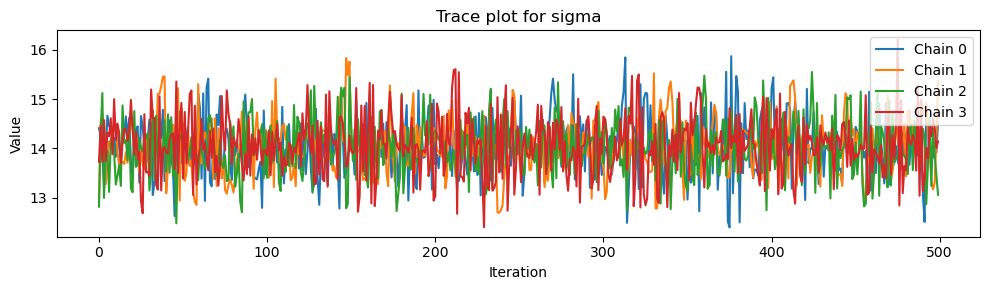

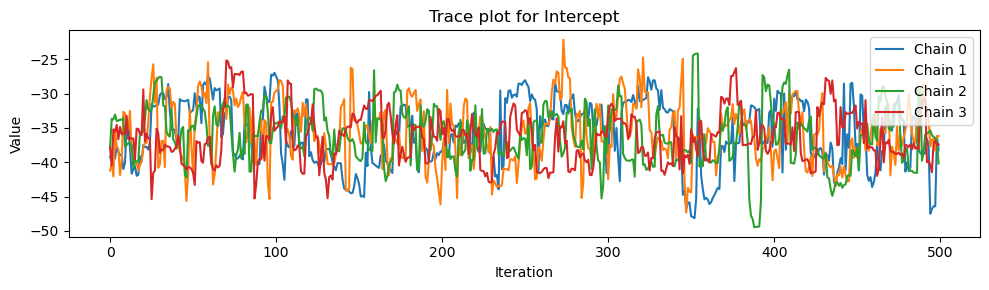

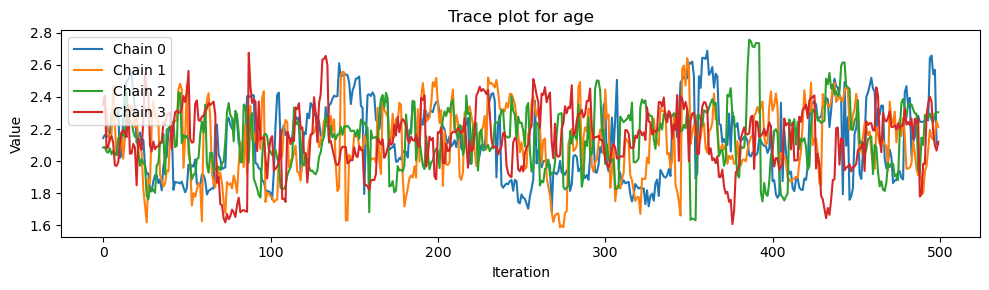

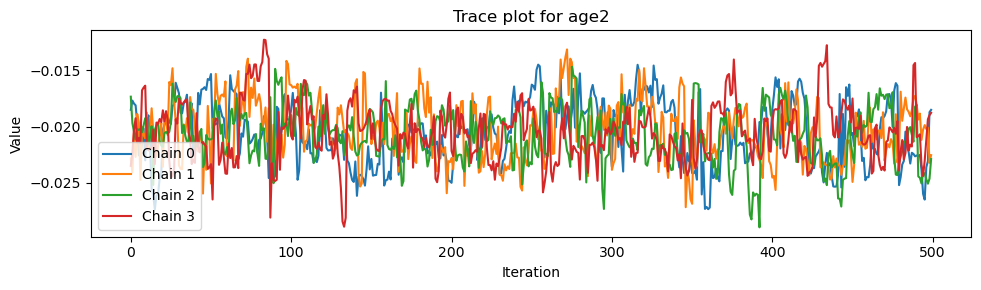

In [8]:
# Extract the posterior samples
## NOTE: The burn in phase is automatically discarded by bambi, so those draws are not shown in the plots
samples = fit_few_samples.posterior

# Extract variable names
parameters = list(samples.keys())

# Plot each parameters trace plot
for param in parameters:
    values = samples[param]
    plt.figure(figsize=(10, 3))
    for chain in range(values.shape[0]):
        plt.plot(values[chain].values, label=f"Chain {chain}")
    plt.title(f"Trace plot for {param}")
    plt.xlabel("Iteration")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()

Alternatively, you can simply make use of the `arviz` library to get the trace plots (and other convergence statistics).

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'age'}>, <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'age2'}>,
        <Axes: title={'center': 'age2'}>]], dtype=object)

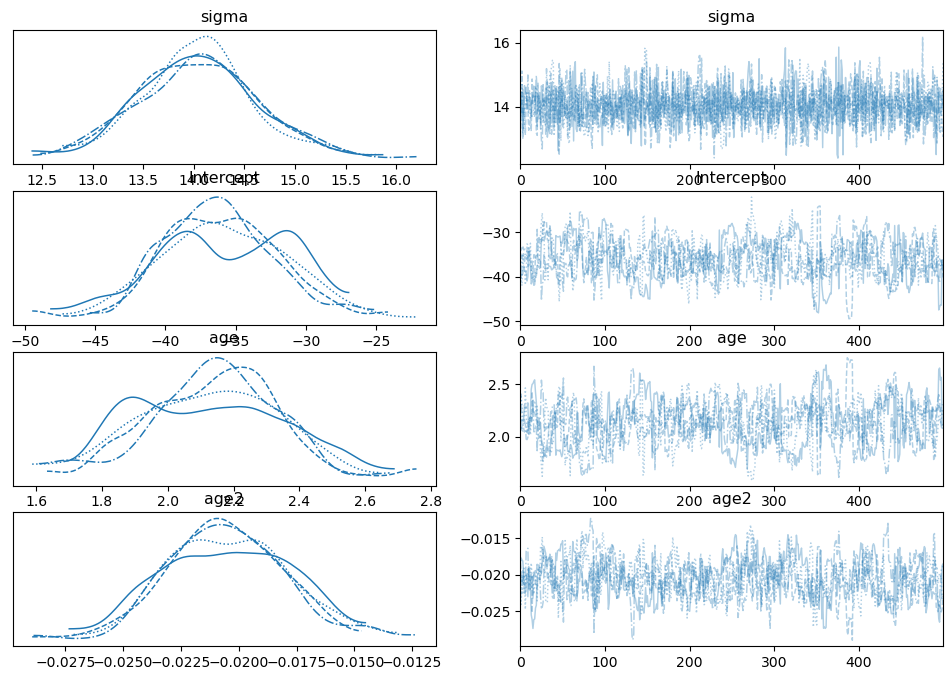

In [9]:
az.plot_trace(fit_few_samples)

It seems like the trace (caterpillar) plots are not neatly converged into one each other (we ideally want one fat caterpillar, like the one for sigma). This indicates we need more samples. Additionally, we get the marginal posterior distribution for each chain, in which we can also see that they differ slightly between the chains, indicating that the sampler hasn't fully converged.

We can check if the chains convergence by having a look at the convergence diagnostics. Two of these diagnostics of interest include the Gelman and Rubin diagnostic and the Effective Sample Size (ESS).

* The Gelman-Rubin Diagnostic shows the PSRF values (using the  within and between chain variability), which all should be close to 1 ($\geq 1.01$). If they aren't close to 1, you should use more iterations. Note: The Gelman and Rubin diagnostic is also automatically given in the summary of bambi under the column `r_hat`.
* The Effective Sample Size (ESS) estimates how many independent samples your MCMC chain is equivalent to, after accounting for autocorrelation. A high ESS means your samples provide a lot of usable information. If ESS is low, it indicates poor mixing, and you may need to run the chain longer.

To obtain the Gelman and Rubin diagnostic use:

In [10]:
az.rhat(fit_few_samples)

<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    sigma      float64 8B 1.0
    Intercept  float64 8B 1.023
    age        float64 8B 1.025
    age2       float64 8B 1.019

Additionally we can use rank plots. Rank plots are histograms of ranked posterior draws, plotted separately for each chain. The rank plots should show a uniform distribution.

array([<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'Intercept'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'age'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'age2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

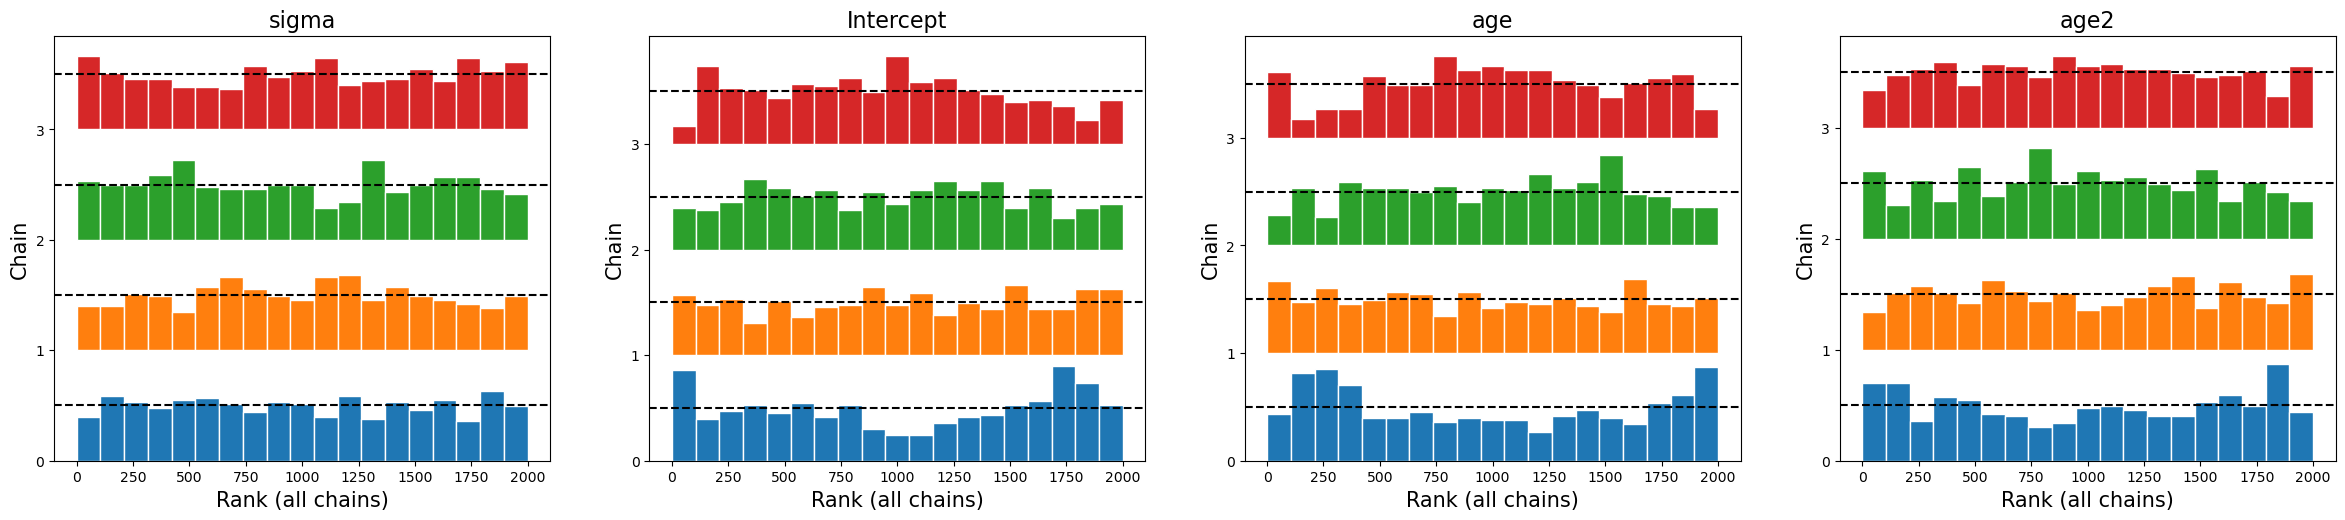

In [11]:
az.plot_rank(fit_few_samples)

To obtain the ESS use:

In [12]:
az.ess(fit_few_samples)

<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    sigma      float64 8B 1.908e+03
    Intercept  float64 8B 254.5
    age        float64 8B 246.3
    age2       float64 8B 302.6

These statistics confirm that the chains have not converged. The plots don't show the fat caterpillars and the ESS is too low. Therefore, we run the same analysis with more samples.

In [13]:
# Specify Model
model = bmb.Model("diff ~ age + age2",
                  data=dataPHD,
                  priors=priors_inf,
                  center_predictors=False)

# Run Model with more iterations
fit = model.fit(random_seed=SEED,
                tune=2000,
                draws=4000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, age2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 93 seconds.


Obtain the trace plots again.

array([[<Axes: title={'center': 'sigma'}>,
        <Axes: title={'center': 'sigma'}>],
       [<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'Intercept'}>],
       [<Axes: title={'center': 'age'}>, <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'age2'}>,
        <Axes: title={'center': 'age2'}>]], dtype=object)

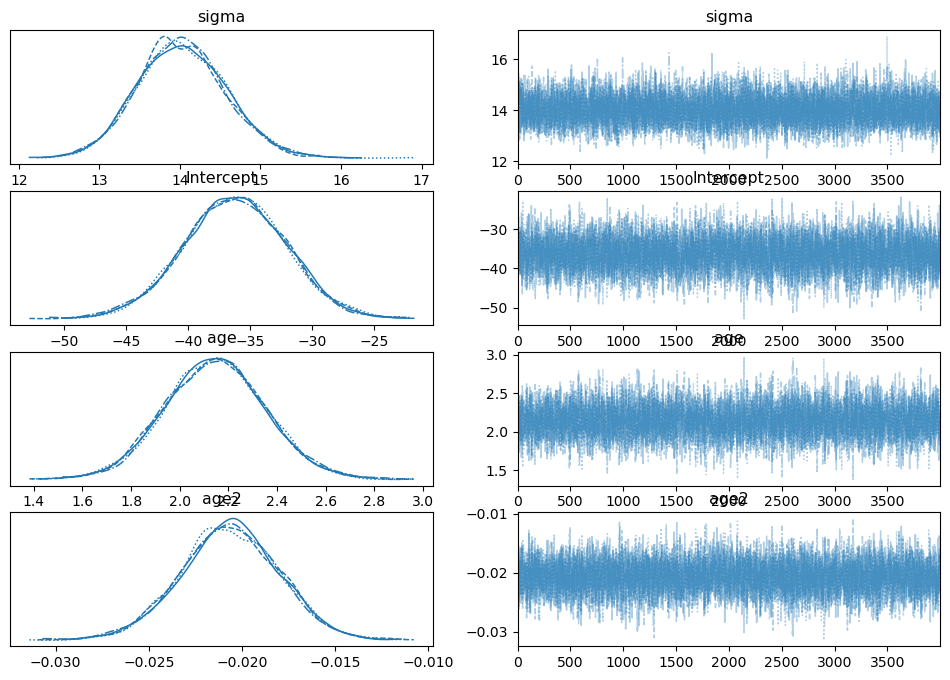

In [14]:
az.plot_trace(fit)

Obtain the Gelman and Rubin diagnostic again.

In [15]:
az.rhat(fit)

<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    sigma      float64 8B 1.001
    Intercept  float64 8B 1.0
    age        float64 8B 1.0
    age2       float64 8B 1.0

array([<Axes: title={'center': 'sigma'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'Intercept'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'age'}, xlabel='Rank (all chains)', ylabel='Chain'>,
       <Axes: title={'center': 'age2'}, xlabel='Rank (all chains)', ylabel='Chain'>],
      dtype=object)

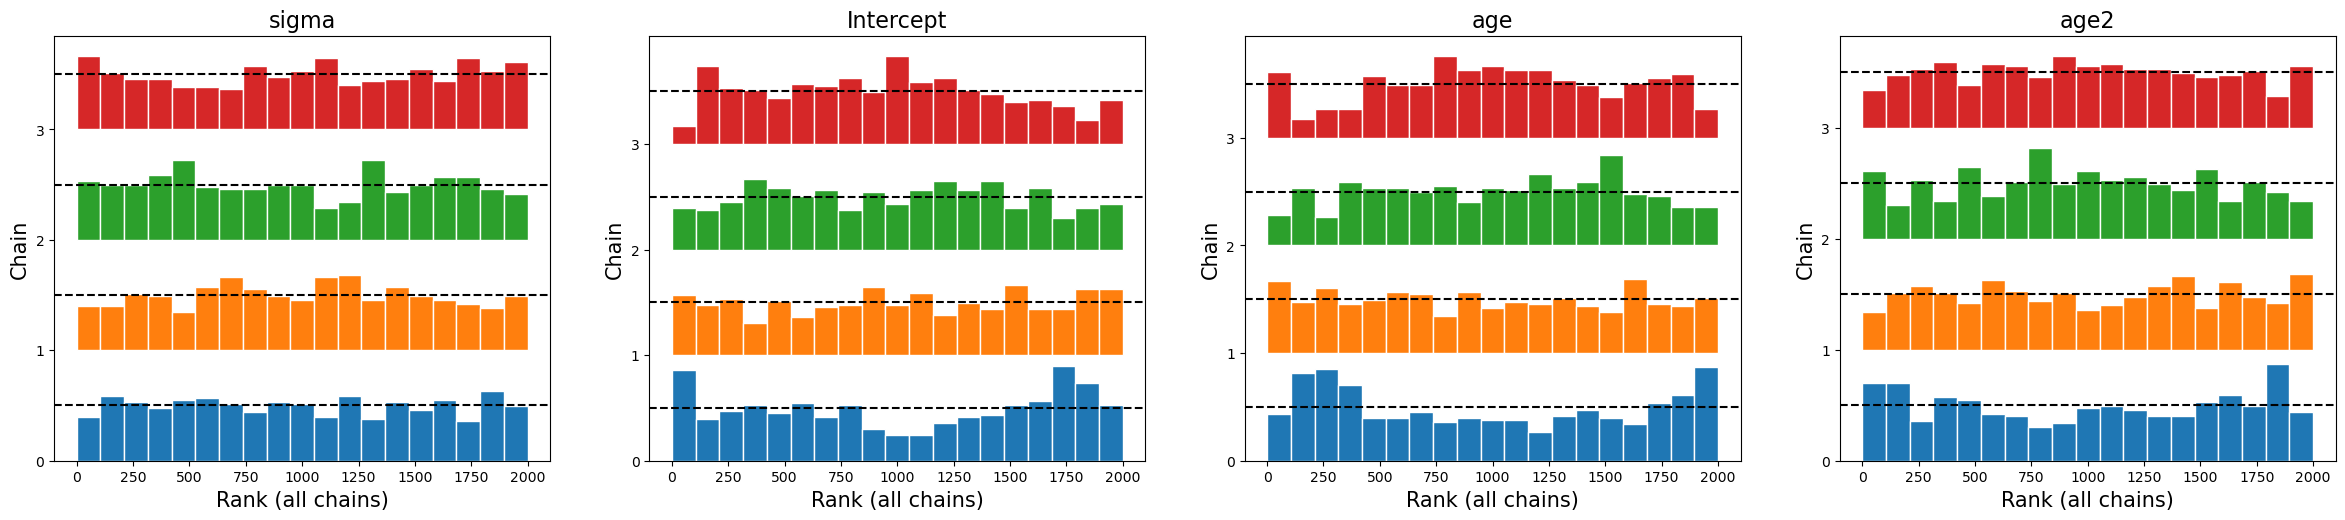

In [16]:
az.plot_rank(fit_few_samples)

Obtain ESS again:

In [17]:
az.ess(fit)

<xarray.Dataset> Size: 32B
Dimensions:    ()
Data variables:
    sigma      float64 8B 7.816e+03
    Intercept  float64 8B 5.322e+03
    age        float64 8B 4.913e+03
    age2       float64 8B 5.472e+03

Now we see that the Gelman and Rubin diagnostic (PRSF) is close to 1 for all parameters and the ESS is sufficiently high.

### 3. Does convergence remain after doubling the number of iterations?

As is recommended in the WAMBS checklist, we double the amount of iterations to check for local convergence.

In [18]:
# Specify Model
model_doubleiter = bmb.Model("diff ~ age + age2",
                             data=dataPHD,
                             priors=priors_inf,
                             center_predictors=False)

# Run Model with double more iterations
fit_doubleiter = model_doubleiter.fit(random_seed=SEED,
                tune=4000,
                draws=8000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, age2]


Output()

Sampling 4 chains for 4_000 tune and 8_000 draw iterations (16_000 + 32_000 draws total) took 148 seconds.


You should again have a look at the above-mentioned convergence statistics, but we can also compute the relative bias to inspect if doubling the number of iterations influences the posterior parameter estimates ($bias= 100*\frac{(model \; with \; double \; iteration \; - \; initial \; converged \; model )}{initial \; converged \; model}$). In order to preserve clarity we  just calculate the bias of the two regression coefficients.

You should combine the relative bias in combination with substantive knowledge about the metric of the parameter of interest to determine when levels of relative deviation are negligible or problematic. For example, with a regression coefficient of 0.001, a 5% relative deviation level might not be substantively relevant. However, with an intercept parameter of 50, a 10% relative deviation level might be quite meaningful. The specific level of relative deviation should be interpreted in the substantive context of the model. Some examples of interpretations are:

- if relative deviation is &lt; |5|%, then do not worry;
- if relative deviation &gt; |5|%, then rerun with 4x nr of iterations.

_**Question:** calculate the relative bias. Are you satisfied with number of iterations, or do you want to re-run the model with even more iterations?_


To get the relative bias simply save the means of the regression coefficients (posterior means) and other parameters for the two different analyses and compute the bias.

### 4.   Does the posterior distribution histogram have enough information?

By having a look at the posterior distribution histogram `az.plot_posterior(fit, kind="hist")`, we can check if it has enough information.

_**Question:** What can you conclude about distribution histograms?_

array([<Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'age'}>, <Axes: title={'center': 'age2'}>],
      dtype=object)

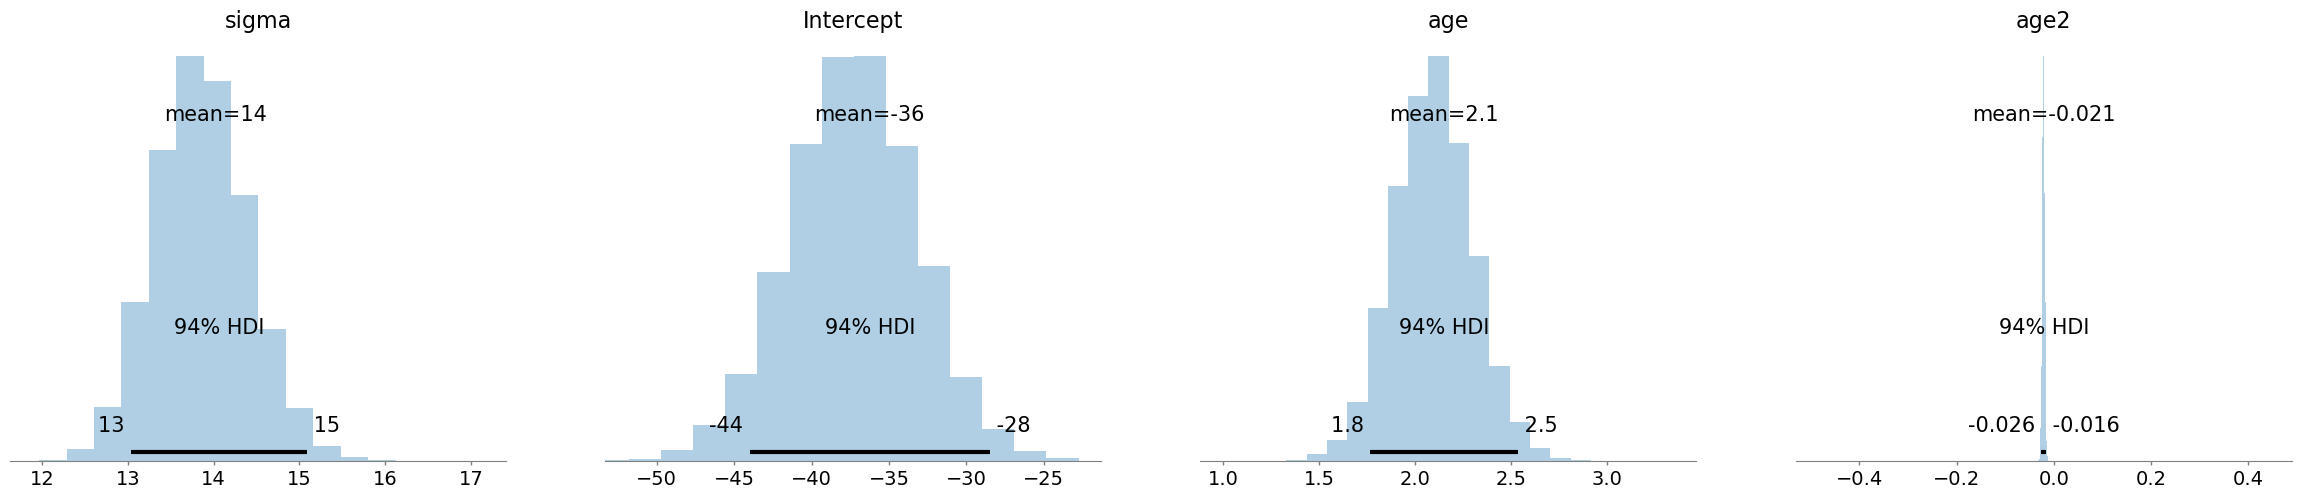

In [19]:
az.plot_posterior(fit, kind="hist")

<details>
<summary>Click to show interpretation</summary>
_The histograms look smooth and have no gaps or other abnormalities. Based on this, adding more iterations is not necessary. However, if you are not satisfied, you can improve the number of iterations again. Posterior distributions do not have to be symmetrical, but in this example they seem to be._
</details>

If we compare this with histograms based on the first analysis (with very few iterations), this difference becomes clear:

array([<Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'age'}>, <Axes: title={'center': 'age2'}>],
      dtype=object)

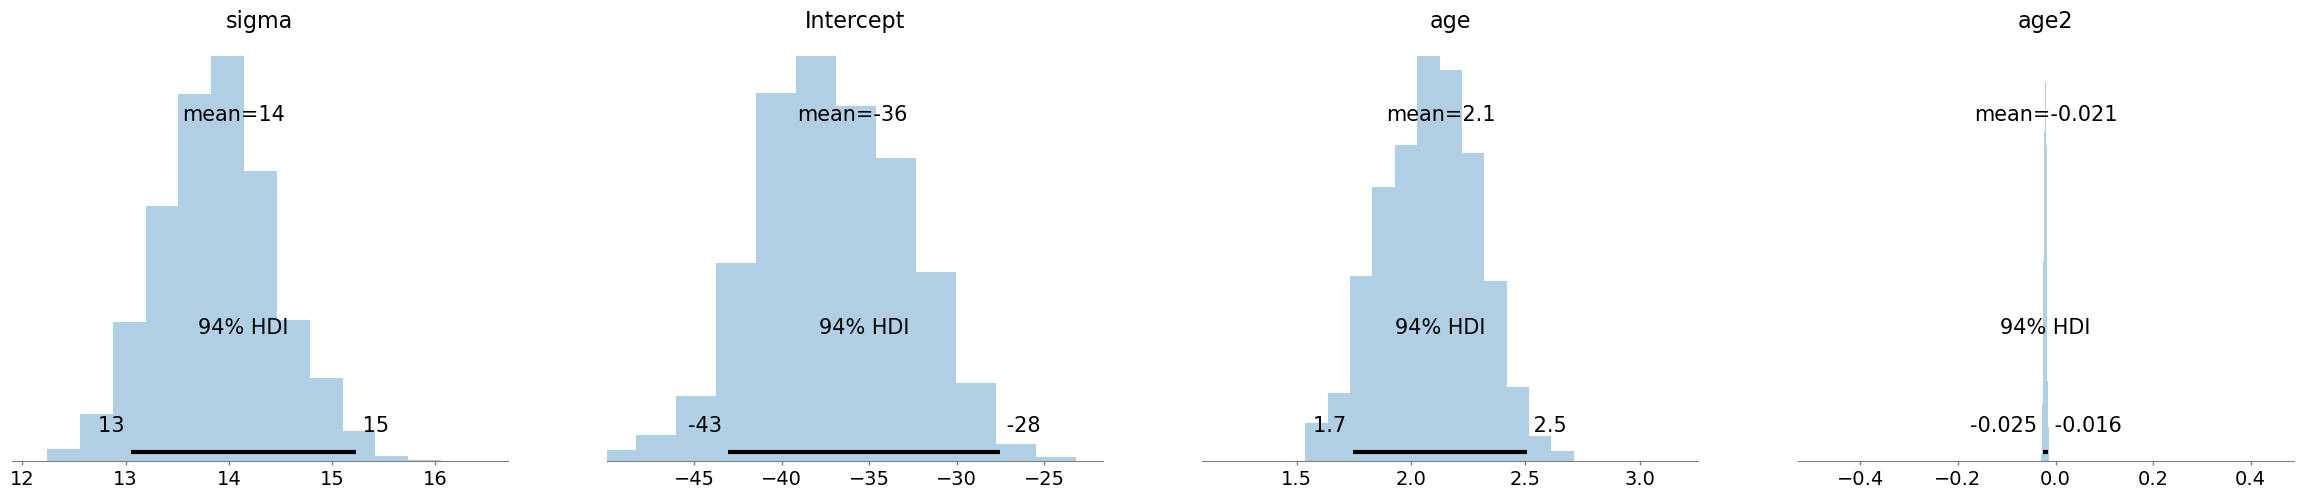

In [20]:
az.plot_posterior(fit_few_samples, kind = "hist")

### 5.   Do the chains exhibit a strong degree of autocorrelation?

To obtain information about autocorrelation the following syntax can be used:

array([[<Axes: title={'center': 'sigma\n0'}>,
        <Axes: title={'center': 'sigma\n1'}>,
        <Axes: title={'center': 'sigma\n2'}>,
        <Axes: title={'center': 'sigma\n3'}>],
       [<Axes: title={'center': 'Intercept\n0'}>,
        <Axes: title={'center': 'Intercept\n1'}>,
        <Axes: title={'center': 'Intercept\n2'}>,
        <Axes: title={'center': 'Intercept\n3'}>],
       [<Axes: title={'center': 'age\n0'}>,
        <Axes: title={'center': 'age\n1'}>,
        <Axes: title={'center': 'age\n2'}>,
        <Axes: title={'center': 'age\n3'}>],
       [<Axes: title={'center': 'age2\n0'}>,
        <Axes: title={'center': 'age2\n1'}>,
        <Axes: title={'center': 'age2\n2'}>,
        <Axes: title={'center': 'age2\n3'}>]], dtype=object)

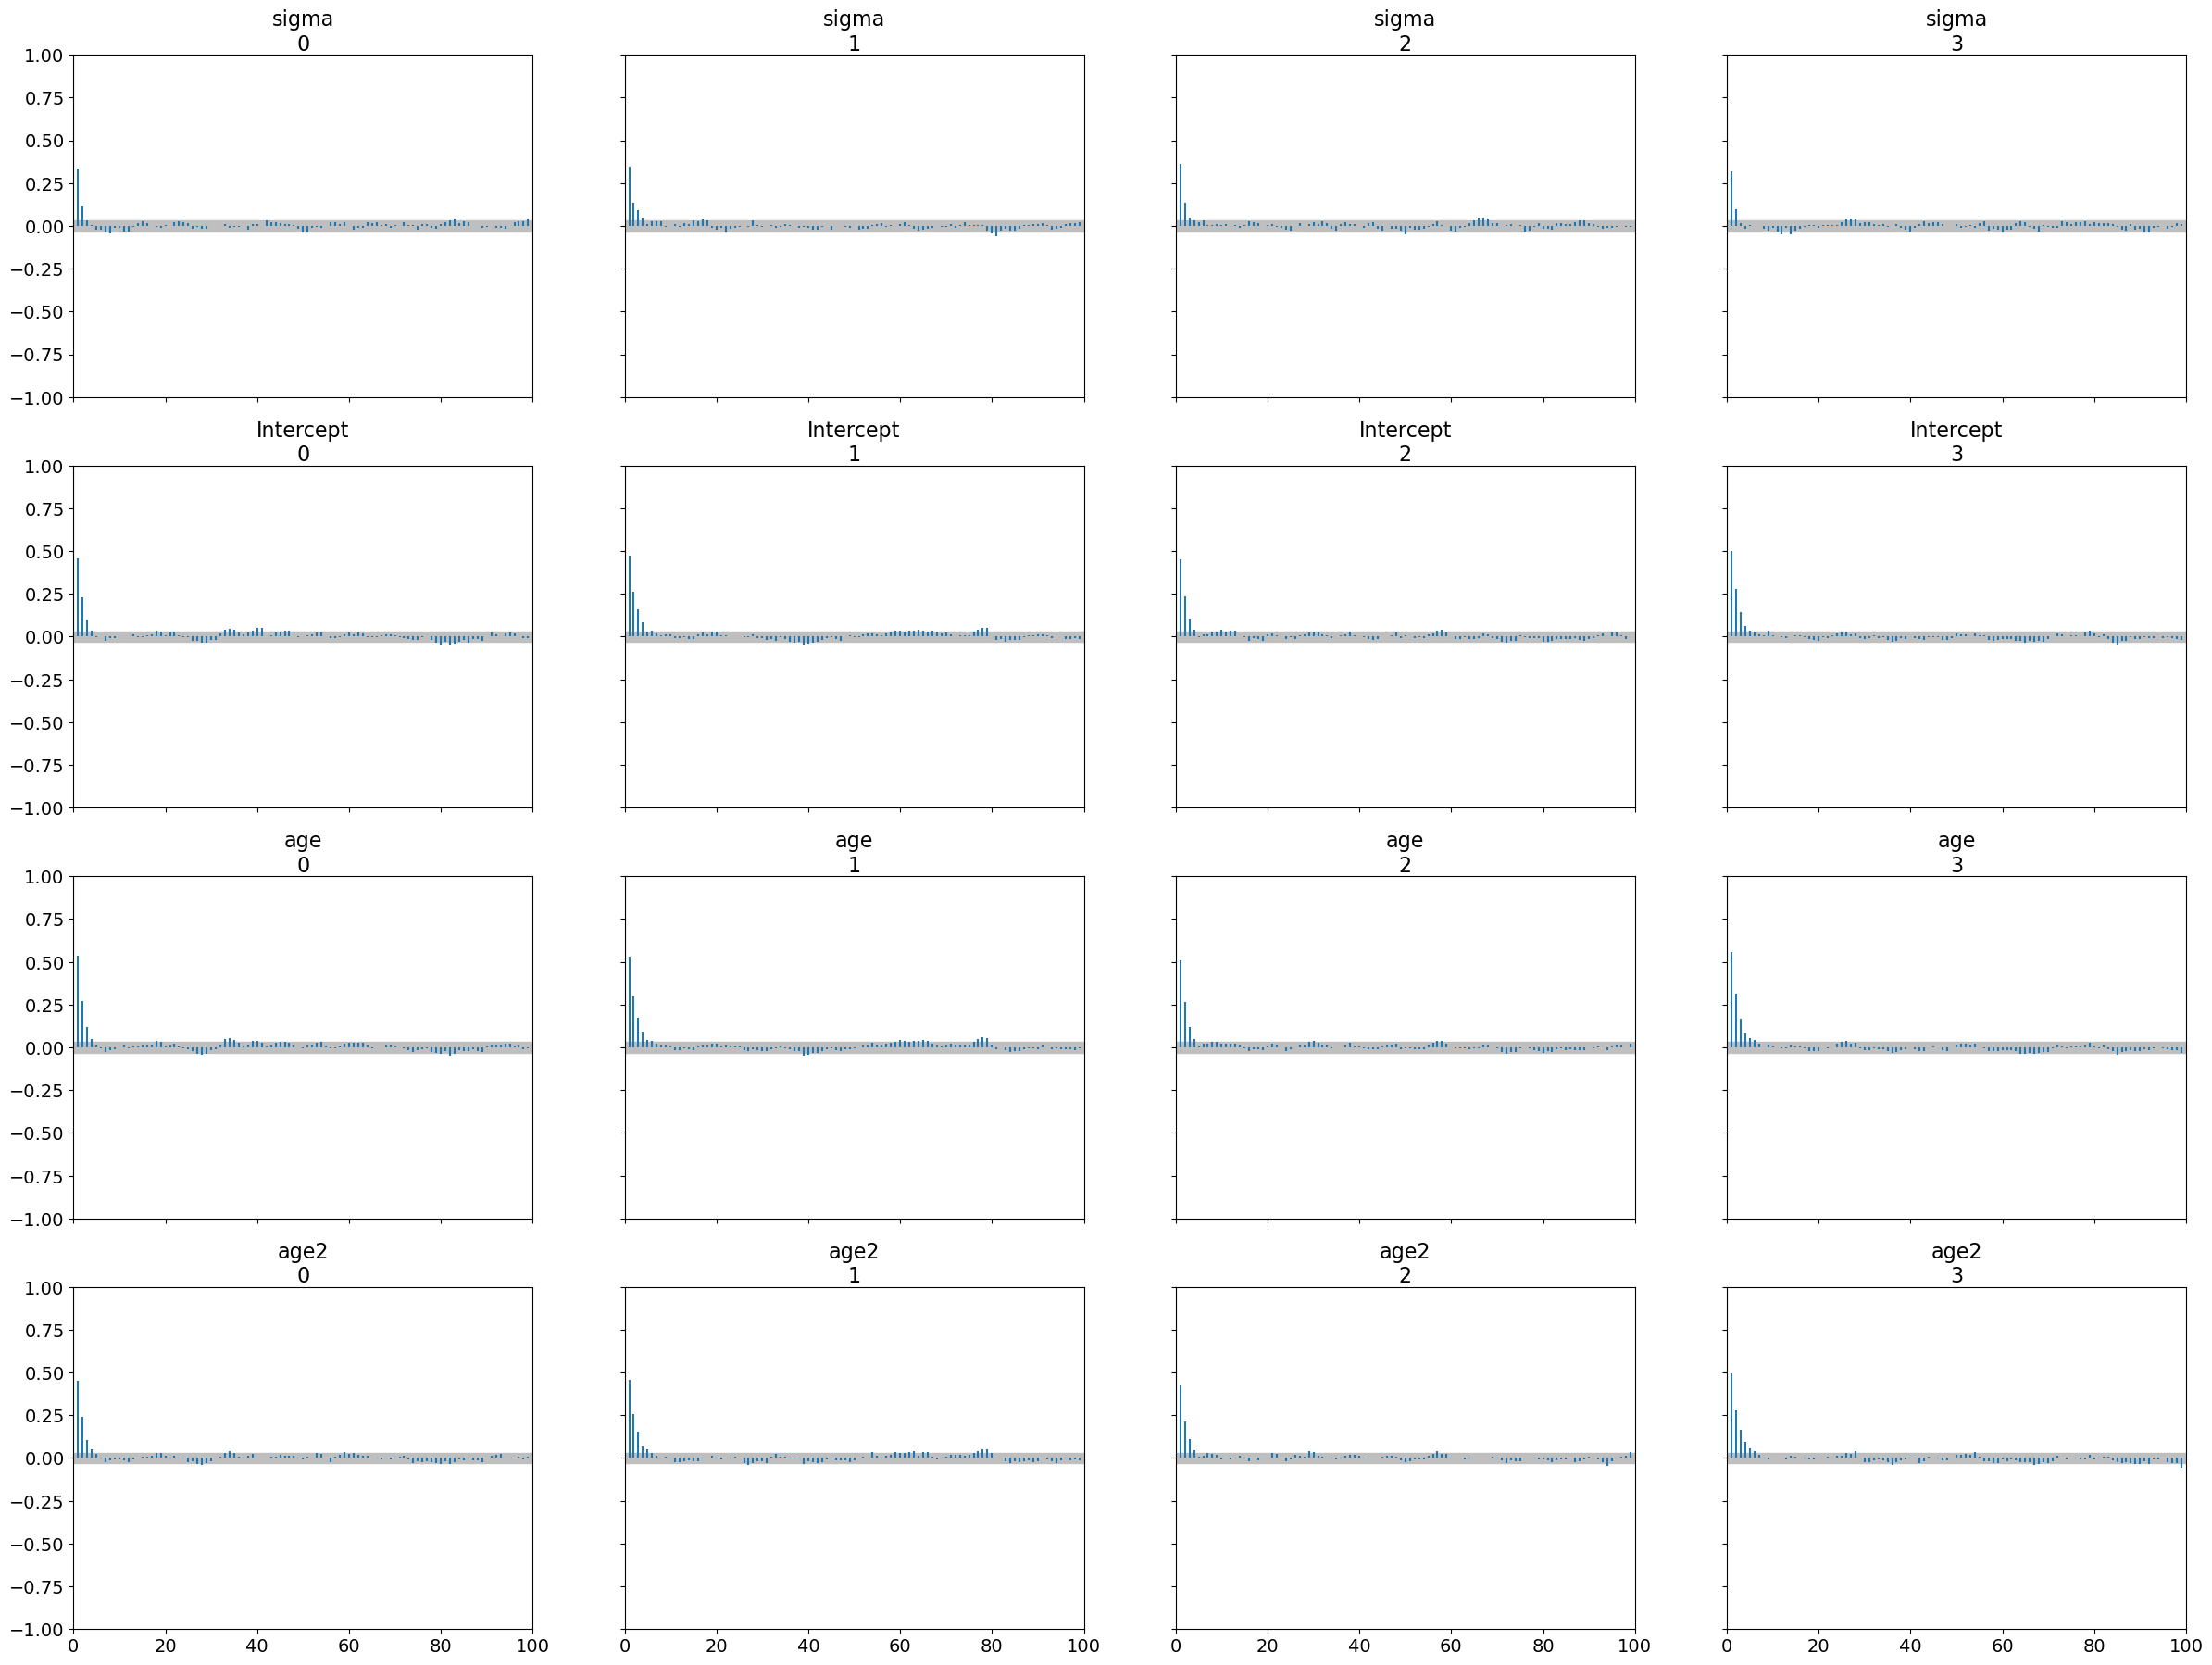

In [21]:
az.plot_autocorr(fit)

_**Question:** What can you conclude about these autocorrelation plots?_

<details>
<summary>Click to show interpretation</summary>
These results show that autocorrelation is quite stong after a few lags. This means it is important to make sure we ran the analysis with a lot of samples, because with a high autocorrelation it will take longer until the whole parameter space has been identified. For more informtation on autocorrelation check this [paper](https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/j.2041-210X.2011.00131.x).
</details>


### 6.   Do the posterior distributions make substantive sense?

We plot the posterior distributions and see if they are unimodel (one peak), if they are clearly centered around one value, if they give a realistic estimate and if they make substantive sense compared to our prior believes (priors). Here we plot the  posteriors of the regression coefficients. If you want you can also plot the mean and the 95% Posterior HPD Intervals.


array([<Axes: title={'center': 'sigma'}>,
       <Axes: title={'center': 'Intercept'}>,
       <Axes: title={'center': 'age'}>, <Axes: title={'center': 'age2'}>],
      dtype=object)

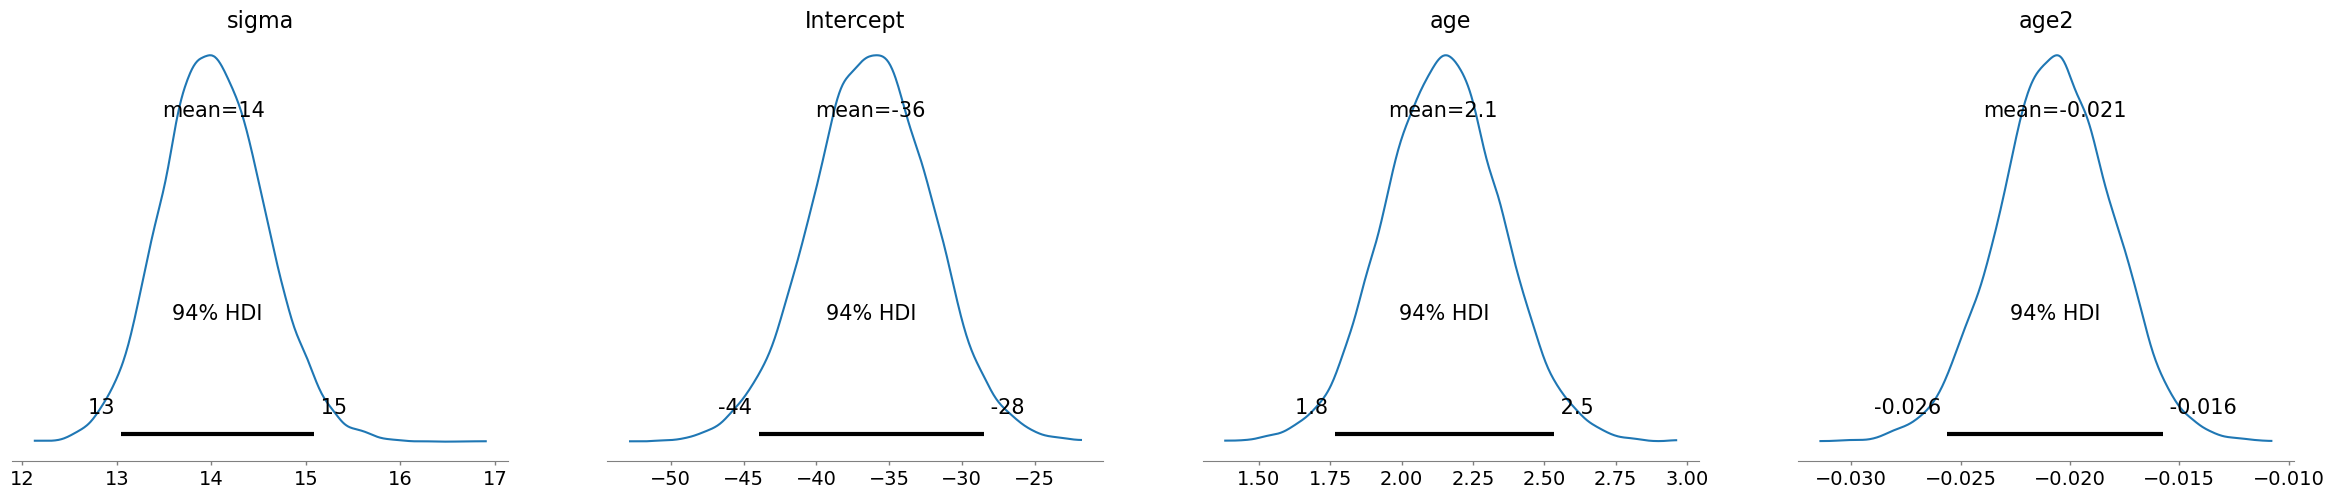

In [22]:
az.plot_posterior(fit)

_**Question:** What is your conclusion; do the posterior distributions make sense?_


<summary>Click to show interpretation</summary>
_Yes, we see a clear negative intercept, which makes sense since a value of age = 0 for Ph.D is impossible. We also have have plausible ranges of values for the regression coefficients and a positive variance._
</details>


## **Step 3: Understanding the exact influence of the priors**

First we  check the results of the analysis with the priors we used so far.

In [23]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,14.024,0.546,13.040,15.085,0.006,0.005,7816.0,8071.0,1.0
Intercept,-36.258,4.112,-43.973,-28.454,0.056,0.041,5322.0,6335.0,1.0
age,2.146,0.205,1.766,2.534,0.003,0.002,4913.0,5602.0,1.0
age2,-0.021,0.003,-0.026,-0.016,0.000,0.000,5472.0,6546.0,1.0


### 7. Do different specification of the variance priors influence the results?

So far we have used the -$\in \sim IG(.5, .5)$ prior, but we can also use the -$\in \sim IG(.01, .01)$ prior and see if doing so makes a difference. To quantify this difference we again calculate a relative bias.

_**Question:** Are the results robust for different specifications of the prior on the residual variance?_


| Parameters | Estimate with $\in \sim IG(.01, .01)$ | Estimate with $\in \sim IG(.5, .5)$ | Bias |
| --- | --- | --- | --- |
| Intercept | |  | |
| Age       | |  | |
| Age2      | |  | |
| Residual variance |  |  |  |


In [24]:
# Specify Priors
prior_age = bmb.Prior("Normal", mu=.8, sigma=2.24)
prior_age2 = bmb.Prior("Normal", mu=.0, sigma=3.16)
prior_int = bmb.Prior("Normal", mu=-35, sigma=4.47)
prior_sigma = bmb.Prior("InverseGamma", alpha=.01, beta=.01)

priors_inf2 = {"Intercept": prior_int, "age": prior_age, "age2": prior_age2, "sigma": prior_sigma}

# Specify Model
model_difIG = bmb.Model("diff ~ age + age2",
                  data=dataPHD,
                  priors=priors_inf2,
                  center_predictors=False)

# Run Model
## tune sets the burn-in samples
## draws sets the post burn-in draws
fit_difIG = model_difIG.fit(random_seed=SEED,
                tune=2000,
                draws=4000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, age2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 80 seconds.


In [26]:
az.summary(fit_difIG)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,14.041,0.550,13.041,15.113,0.006,0.005,7308.0,7950.0,1.0
Intercept,-36.190,4.175,-43.574,-27.809,0.058,0.042,5125.0,6533.0,1.0
age,2.143,0.209,1.739,2.529,0.003,0.002,4726.0,5445.0,1.0
age2,-0.021,0.003,-0.026,-0.016,0.000,0.000,5282.0,6590.0,1.0


### 8.   Is there a notable effect of the prior when compared with non-informative priors?

The default bambi priors are non-informative, so we can run the analysis without any specified priors and compare them to the model we have run thus far, using the relative bias, to see if there is a large influence of the priors.


_**Question**: What is your conclusion about the influence of the priors on the posterior results?_

| Parameters | Estimates with default priors | Estimate with informative priors | Bias|
| --- | --- | --- | --- |
| Intercept |  |      |  |
| Age |  |  | |
| Age2 |  |  ||
| Residual variance | |  |  |

From the brms manual we learn that:

1. *The default prior for population-level effects (including monotonic and category specific effects) is an improper flat prior over the reals."*
2. *"By default, sigma has a half student-t prior that scales in the same way as the group-level standard deviations."*

We can run the model without our priors and check if doing so strongly influences the results.

In [28]:
# Specify Model
model_default = bmb.Model("diff ~ age + age2",
                  data=dataPHD,
                  center_predictors=False)

# Run Model
## tune sets the burn-in samples
## draws sets the post burn-in draws
fit_default = model_default.fit(random_seed=SEED,
                tune=2000,
                draws=4000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, age, age2]


Output()

Sampling 4 chains for 2_000 tune and 4_000 draw iterations (8_000 + 16_000 draws total) took 147 seconds.


In [29]:
az.summary(fit_default)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,14.047,0.557,12.971,15.077,0.007,0.006,6549.0,6436.0,1.0
Intercept,-45.541,12.282,-67.499,-21.420,0.206,0.139,3554.0,4774.0,1.0
age,2.584,0.583,1.429,3.626,0.010,0.007,3505.0,4606.0,1.0
age2,-0.025,0.006,-0.037,-0.014,0.000,0.000,3588.0,4693.0,1.0


_**Question**: Which results do you use to draw conclusion on?_

<details>
<summary>Click to show interpretation</summary>
This really depends on where the priors come from. If for example your informative priors come from a reliable source, you should use them. The most important thing is that you choose your priors accurately, and have good arguments to use them. If not, you shouldn&#39;t use really informative priors and use the results based on the non-informative priors.
</details>

### 9.   Are the results stable from a sensitivity analysis?

If you still have time left, you can adjust the hyperparameters of the priors upward and downward and re-estimating the model with these varied priors to check for robustness.

From the original paper:

> "If informative or weakly-informative priors are used, then we suggest running a sensitivity analysis of these priors. When subjective priors are in place, then there might be a discrepancy between results using different subjective prior settings. A sensitivity analysis for priors would entail adjusting the entire prior distribution (i.e., using a completely different prior distribution than before) or adjusting hyperparameters upward and downward and re-estimating the model with these varied priors. Several different hyperparameter specifications can be made in a sensitivity analysis, and results obtained will point toward the impact of small fluctuations in hyperparameter values. [...] The purpose of this sensitivity analysis is to assess how much of an impact the location of the mean hyperparameter for the prior has on the posterior. [...] Upon receiving results from the sensitivity analysis, assess the impact that fluctuations in the hyperparameter values have on the substantive conclusions. Results may be stable across the sensitivity analysis, or they may be highly instable based on substantive conclusions. Whatever the finding, this information is important to report in the results and discussion sections of a paper. We should also reiterate here that original priors should not be modified, despite the results obtained."


For more information on this topic, please also refer to this [paper](http://psycnet.apa.org/record/2017-52406-001).

### 10.   Is the Bayesian way of interpreting and reporting model results used?

For a summary on how to interpret and report models, please refer to https://www.rensvandeschoot.com/bayesian-analyses-where-to-start-and-what-to-report/

In [60]:
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,14.024,0.546,13.040,15.085,0.006,0.005,7816.0,8071.0,1.0
Intercept,-36.258,4.112,-43.973,-28.454,0.056,0.041,5322.0,6335.0,1.0
age,2.146,0.205,1.766,2.534,0.003,0.002,4913.0,5602.0,1.0
age2,-0.021,0.003,-0.026,-0.016,0.000,0.000,5472.0,6546.0,1.0


In the current model we see that:

*  The estimate for the intercept is -36.26 [-43.97;-28.45]
*  The estimate for the effect of $age$  is 2.14 [1.77;2.53]
*  The estimate for the effect of $age^2$  is -0.02 [-0.03;-0.02]


We can see that none of 95% Posterior HPD Intervals for these effects include zero, which means we are can be quite certain that all of the effects are different from 0.

Remember how we plotted the relation between delay and years based on the prior information? Now, do the same with the posterior estimates.


In [ ]:
years = np.arange(20, 81)  # 20 to 80 inclusive
delay = -35 + 2.13 * years - 0.02 * years**2

plt.plot(years, delay, linestyle='-')
plt.xlabel("Years")
plt.ylabel("Delay")
plt.title("Delay vs Years")
plt.show()

**References**


Depaoli, S., &amp; Van de Schoot, R. (2017). Improving transparency and replication in Bayesian statistics: The WAMBS-Checklist. _Psychological Methods_, _22_(2), 240.

Link, W. A., & Eaton, M. J. (2012). On thinning of chains in MCMC. _Methods in ecology and evolution_, _3_(1), 112-115.

van Erp, S., Mulder, J., & Oberski, D. L. (2017). Prior sensitivity analysis in default Bayesian structural equation modeling.

Van de Schoot, R., &amp; Depaoli, S. (2014). Bayesian analyses: Where to start and what to report. _European Health Psychologist_, _16_(2), 75-84.

## Original Computing Environment

In [64]:
import session_info
session_info.show()

C:\Users\fmetwaly\AppData\Local\anaconda3\envs\BayesEst\Lib\site-packages\session_info\main.py:213: UserWarning: The '__version__' attribute is deprecated and will be removed in MarkupSafe 3.1. Use feature detection, or `importlib.metadata.version("markupsafe")`, instead.
  mod_version = _find_version(mod.__version__)
